In [2]:
! pip install -q transformers==4.24.0
!pip install -q gradio
!sudo apt-get install git-lfs
!git lfs install

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
kaggle-environments 1.14.3 requires transformers>=4.33.1, but you have transformers 4.24.0 which is incompatible.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
git-lfs is already the newest version (2.9.2-1).
0 upgraded, 0 newly installed, 0 to remove and 30 not upgraded.
Error: Failed to call git rev-parse --git-dir: exit status 128 
Git LFS initialized.


In [3]:
import os
import wandb
import torch
import pickle
import numpy as np
%matplotlib inline
import pandas as pd
import gradio as gr
import seaborn as sns
import tensorflow as tf
from typing import Dict
from ast import literal_eval
from torch.optim import AdamW
from tqdm import tqdm, trange
import matplotlib.pyplot as plt
from kaggle_secrets import UserSecretsClient
from torch.nn import BCEWithLogitsLoss, BCELoss
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from keras.preprocessing.sequence import pad_sequences
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from sklearn.metrics import classification_report, confusion_matrix, multilabel_confusion_matrix, f1_score, accuracy_score
from transformers import XLNetForSequenceClassification, XLNetTokenizer,BertForSequenceClassification,BertTokenizer, RobertaForSequenceClassification,RobertaTokenizer


2024-02-04 09:31:55.780960: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-04 09:31:55.781115: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-04 09:31:55.929321: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [5]:
torch.__version__

'2.1.2'

In [6]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

'Tesla T4'

In [8]:
try:
    from kaggle_secrets import UserSecretsClient
    user_secrets = UserSecretsClient()
    secret_value_0 = user_secrets.get_secret("wandb_api")
    wandb.login(key=secret_value_0)
    anony=None
except:
    anony = "must"
    print('If you want to use your W&B account, go to Add-ons -> Secrets and provide your W&B access token. Use the Label name as wandb_api. \nGet your W&B access token from here: https://wandb.ai/authorize')
    
    
    
wandb.init(project="Multi Label Classification of PubMed Articles (Paper Night Presentation)",name=f"42.Biobert-base-cased-v1.2-Run-27")

If you want to use your W&B account, go to Add-ons -> Secrets and provide your W&B access token. Use the Label name as wandb_api. 
Get your W&B access token from here: https://wandb.ai/authorize


wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [78]:
dataset_Name='../input/pubmed-multilabel-text-classification/PubMed Multi Label Text Classification Dataset Processed.csv'

df= pd.read_csv(dataset_Name)
df.head(3)

,Title,abstractText,meshMajor,pmid,meshid,meshroot,A,B,C,D,E,F,G,H,I,J,L,M,N,Z
0,Expression of p53 and coexistence of HPV in pr...,Fifty-four paraffin embedded tissue sections f...,"['DNA Probes, HPV', 'DNA, Viral', 'Female', 'H...",8549602,"[['D13.444.600.223.555', 'D27.505.259.750.600....","['Chemicals and Drugs [D]', 'Organisms [B]', '...",0,1,1,1,1,0,0,1,0,0,0,0,0,0
1,Vitamin D status in pregnant Indian women acro...,The present cross-sectional study was conducte...,"['Adult', 'Alkaline Phosphatase', 'Breast Feed...",21736816,"[['M01.060.116'], ['D08.811.277.352.650.035'],...","['Named Groups [M]', 'Chemicals and Drugs [D]'...",0,1,1,1,1,1,1,0,1,1,0,1,1,1
2,[Identification of a functionally important di...,The occurrence of individual amino acids and d...,"['Amino Acid Sequence', 'Analgesics, Opioid', ...",19060934,"[['G02.111.570.060', 'L01.453.245.667.060'], [...","['Phenomena and Processes [G]', 'Information S...",1,1,0,1,1,0,1,0,0,0,1,0,0,0


In [10]:
print("Total number of Articles extracted from Bioasq dataset are =",len(df))

Total number of Articles extracted from Bioasq dataset are = 50000


In [11]:
print('Average Article length: ', df.abstractText.str.split().str.len().mean())
print('Stdev Article length: ', df.abstractText.str.split().str.len().std())

Average Article length:  192.05284
Stdev Article length:  76.74764082329723


In [12]:
cols = df.columns
cols = list(df.columns)
mesh_Heading_categories = cols[6:]
num_labels = len(mesh_Heading_categories)
print('Mesh Labels Root Class: "\n"',mesh_Heading_categories)
print("\n")
print('Number of Labels: ' ,num_labels)

Mesh Labels Root Class: "
" ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'L', 'M', 'N', 'Z']


Number of Labels:  14


In [13]:
%%time

counts = []
for mesh_Heading_category in mesh_Heading_categories:
    counts.append((mesh_Heading_category, df[mesh_Heading_category].sum()))
df_count = pd.DataFrame(counts, columns=['Root Label', 'number of Abstract'])
df_count

CPU times: user 2.98 ms, sys: 853 µs, total: 3.84 ms
Wall time: 3.41 ms


,Root Label,number of Abstract
0,A,23263
1,B,46577
2,C,26453
3,D,31074
4,E,39202
5,F,8885
6,G,33609
7,H,6069
8,I,5595
9,J,5531


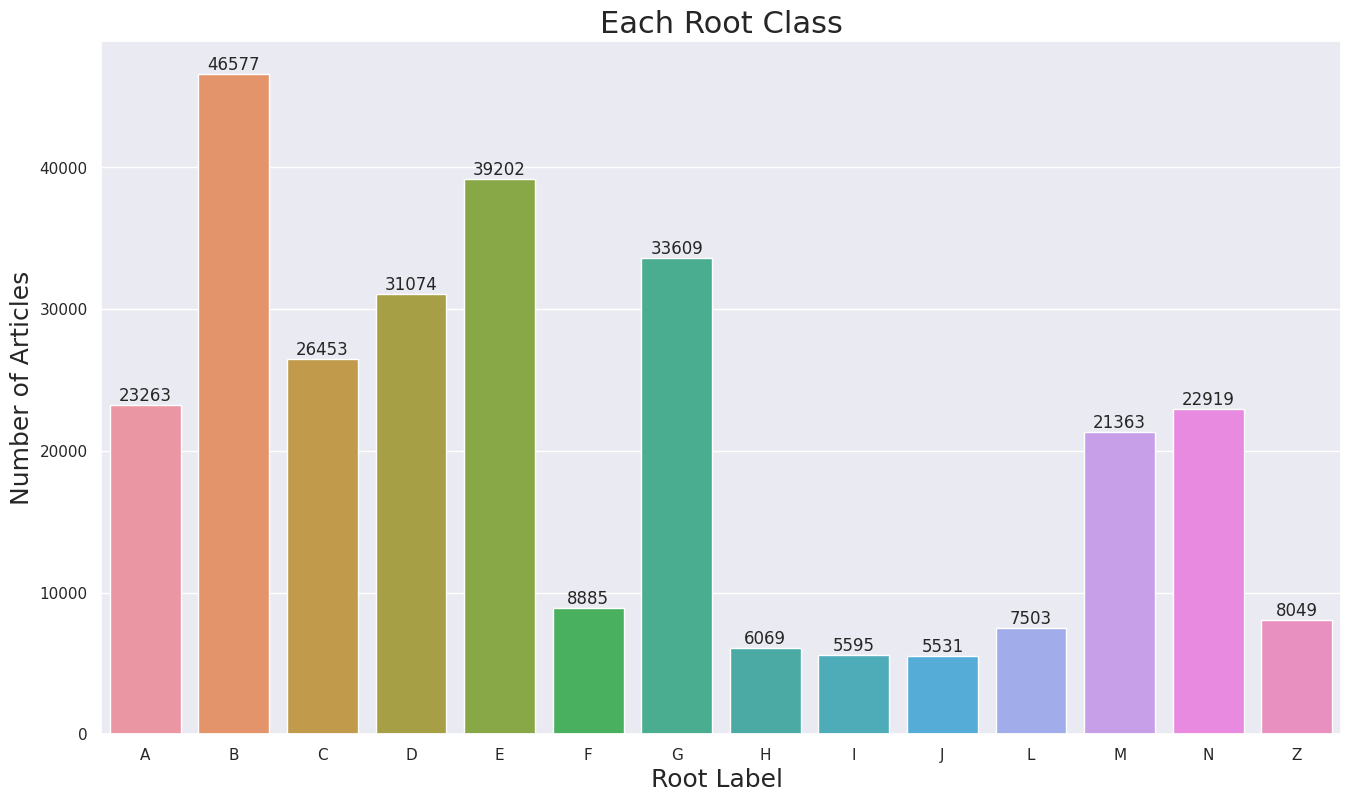

CPU times: user 446 ms, sys: 4.77 ms, total: 451 ms
Wall time: 474 ms


In [14]:
%%time
sns.set(font_scale = 1)
plt.figure(figsize=(16,9))
ax= sns.barplot(x=mesh_Heading_categories, y=df.iloc[:,6:].sum().values)
plt.title("Each Root Class", fontsize=22)
plt.ylabel('Number of Articles', fontsize=18)
plt.xlabel('Root Label ', fontsize=18)

#adding the text labels
rects = ax.patches
labels = df.iloc[:,6:].sum().values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom', fontsize=12)

plt.show()

In [15]:
df_train, df_test = train_test_split(df, random_state=32, test_size=0.20, shuffle=True)
print(df_train.shape)
print(df_test.shape)
del(df)

(40000, 20)
(10000, 20)


In [16]:
df_train['one_hot_labels'] = list(df_train[mesh_Heading_categories].values)
df_train.head(3)

,Title,abstractText,meshMajor,pmid,meshid,meshroot,A,B,C,D,...,F,G,H,I,J,L,M,N,Z,one_hot_labels
31112,Neurofibromatosis associated with a coronary a...,A case of a patient with type 1 neurofibromato...,"['Aged', 'Coronary Aneurysm', 'Humans', 'Male'...",11144803,"[['M01.060.116.100'], ['C14.280.647.250.250', ...","['Named Groups [M]', 'Diseases [C]', 'Organism...",0,1,1,0,...,0,0,0,0,0,0,1,0,0,"[0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0]"
48911,Phenolic constituents from Perovskia atriplici...,"Perovskoate, an isorinic acid derivative (1) a...","['Caffeic Acids', 'Catechols', 'Cholinesterase...",16644529,"[['D02.241.223.200.054'], ['D02.455.426.559.38...","['Chemicals and Drugs [D]', 'Analytical, Diagn...",0,1,0,1,...,0,1,0,0,0,0,0,0,0,"[0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0]"
16394,Motion artifact and background noise suppressi...,Optical coherence tomography (OCT) is a techni...,"['Algorithms', 'Angiography', 'Artifacts', 'Ar...",25089975,"[['G17.035', 'L01.224.050'], ['E01.370.350.700...","['Phenomena and Processes [G]', 'Information S...",0,0,0,0,...,0,1,0,0,0,1,0,1,0,"[0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0]"


In [17]:
labels = list(df_train.one_hot_labels.values)
Article_train = list(df_train.abstractText.values)

## RoBerta

In [18]:
%%time
max_length = 128
tokenizer = RobertaTokenizer.from_pretrained('distilroberta-base', do_lower_case=False)

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

CPU times: user 168 ms, sys: 24.2 ms, total: 192 ms
Wall time: 883 ms


In [19]:
encodings = tokenizer.batch_encode_plus(Article_train,max_length=max_length,padding=True,truncation=True) # tokenizer's encoding method
print('tokenizer outputs: ', encodings.keys())

input_ids = encodings['input_ids'] # tokenized and encoded sentences
attention_masks = encodings['attention_mask'] # attention masks

tokenizer outputs:  dict_keys(['input_ids', 'attention_mask'])


In [20]:
label_counts = df_train.one_hot_labels.astype(str).value_counts()
one_freq = label_counts[label_counts==1].keys()
one_freq_idxs = sorted(list(df_train[df_train.one_hot_labels.astype(str).isin(one_freq)].index), reverse=True)
print('df label indices with only one instance: ', one_freq_idxs)

df label indices with only one instance:  [49950, 49878, 49876, 49838, 49759, 49739, 49696, 49590, 49585, 49574, 49546, 49535, 49528, 49487, 49470, 49419, 49404, 49395, 49314, 49245, 49150, 49080, 49071, 49058, 49004, 48991, 48982, 48922, 48919, 48757, 48708, 48686, 48679, 48677, 48602, 48594, 48583, 48531, 48454, 48438, 48411, 48388, 48375, 48350, 48337, 48298, 48213, 48185, 48123, 48085, 48075, 48056, 48020, 48001, 47876, 47840, 47828, 47817, 47776, 47671, 47495, 47435, 47369, 47363, 47362, 47359, 47356, 47321, 47293, 47244, 47239, 47159, 47104, 47089, 47061, 47050, 47002, 46955, 46887, 46874, 46837, 46747, 46706, 46651, 46635, 46598, 46446, 46365, 46247, 46223, 46199, 46170, 46033, 46028, 45955, 45946, 45756, 45755, 45712, 45682, 45671, 45573, 45509, 45430, 45391, 45317, 45294, 45226, 45216, 45190, 45134, 45132, 45105, 45052, 45035, 45025, 44971, 44953, 44867, 44851, 44827, 44777, 44763, 44625, 44606, 44598, 44586, 44579, 44574, 44568, 44499, 44479, 44462, 44296, 44206, 44181, 44116

In [21]:
train_inputs, validation_inputs, train_labels, validation_labels, train_masks, validation_masks = train_test_split(input_ids, labels, attention_masks,
                                                            random_state=2020, test_size=0.20)

# Convert all of our data into torch tensors, the required datatype for our BERT Pytorch model
train_inputs = torch.tensor(train_inputs)
train_labels = torch.tensor(train_labels)
train_masks = torch.tensor(train_masks)

validation_inputs = torch.tensor(validation_inputs)
validation_labels = torch.tensor(validation_labels)
validation_masks = torch.tensor(validation_masks)

/tmp/ipykernel_34/3945525124.py:6: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:261.)
  train_labels = torch.tensor(train_labels)


In [22]:
batch_size = 64

# Create an iterator of our data with torch DataLoader. This helps save on memory during training because, unlike a for loop, 
# with an iterator the entire dataset does not need to be loaded into memory
train_data =     TensorDataset(train_inputs, train_masks, train_labels,)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels,)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

In [23]:
torch.save(validation_dataloader,'validation_data_loader')
torch.save(train_dataloader,'train_data_loader')

In [24]:
model = RobertaForSequenceClassification.from_pretrained('distilroberta-base', num_labels=num_labels)

model.safetensors:   0%|          | 0.00/331M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilroberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.out_proj.bias', 'classifier.dense.bias'

In [25]:
model.cuda()
print('Model Pushed to Cuda for Training')

Model Pushed to Cuda for Training


In [26]:
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

In [27]:
optimizer = AdamW(optimizer_grouped_parameters,lr=6e-6)

In [28]:
os.environ['TF_FORCE_GPU_ALLOW_GROWTH']='true'

In [29]:
%%time

# For Storing our loss and accuracy for plotting
train_loss_set = []
val_f1_accuracy_list,val_flat_accuracy_list,training_loss_list,epochs_list=[],[],[],[]

# Number of training epochs (recommend between 5 and 10)
epochs = 6

# trange is a tqdm wrapper around the normal python range
for _ in trange(epochs, desc="Epoch "):
    # Training

    # Set our model to training mode (as opposed to evaluation mode)
    model.train()

    # Tracking variables
    tr_loss = 0 #running loss
    nb_tr_examples, nb_tr_steps = 0, 0
  
    # Train the data for one epoch
    for step, batch in enumerate(train_dataloader):
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels= batch
        # Clear out the gradients (by default they accumulate)
        optimizer.zero_grad()
        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
        logits = outputs[0]
        loss_func = BCEWithLogitsLoss()  
        loss = loss_func(logits.view(-1,num_labels),b_labels.type_as(logits).view(-1,num_labels)) #convert labels to float for calculation
        
        train_loss_set.append(loss.item())    

        # Backward pass
        loss.backward()
        # Update parameters and take a step using the computed gradient
        optimizer.step()
        # scheduler.step()
        # Update tracking variables
        tr_loss += loss.item()
        nb_tr_examples += b_input_ids.size(0)
        nb_tr_steps += 1

    print("Train loss: {}".format(tr_loss/nb_tr_steps))
    training_loss_list.append(tr_loss/nb_tr_steps)

    ###############################################################################

    # Validation

    # Put model in evaluation mode to evaluate loss on the validation set
    model.eval()

    # Variables to gather full output
    logit_preds,true_labels,pred_labels,tokenized_texts = [],[],[],[]

    # Predict
    for i, batch in enumerate(validation_dataloader):
        batch = tuple(t.to(device) for t in batch)
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        with torch.no_grad():
            # Forward pass
            outs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
            b_logit_pred = outs[0]
            pred_label = torch.sigmoid(b_logit_pred)

        b_logit_pred = b_logit_pred.detach().cpu().numpy()
        pred_label = pred_label.to('cpu').numpy()
        b_labels = b_labels.to('cpu').numpy()

    tokenized_texts.append(b_input_ids)
    logit_preds.append(b_logit_pred)
    true_labels.append(b_labels)
    pred_labels.append(pred_label)

    # Flatten outputs
    pred_labels = [item for sublist in pred_labels for item in sublist]
    true_labels = [item for sublist in true_labels for item in sublist]

    # Calculate Accuracy
    threshold = 0.50
    pred_bools = [pl>threshold for pl in pred_labels]
    true_bools = [tl==1 for tl in true_labels]
    val_f1_accuracy = f1_score(true_bools,pred_bools,average='micro')*100
    val_flat_accuracy = accuracy_score(true_bools, pred_bools)*100

    print('F1 Validation Accuracy: ', val_f1_accuracy)  
    print('Flat Validation Accuracy: ', val_flat_accuracy)
    print('\n')
    val_f1_accuracy_list.append(val_f1_accuracy)
    val_flat_accuracy_list.append(val_flat_accuracy)
    epochs_list.append(epochs)  
    
    wandb.log({"train_loss":tr_loss/nb_tr_steps,"val_f1_accuracy":val_f1_accuracy,"val_flat_accuracy":val_flat_accuracy,})
wandb.finish()

Epoch :   0%|          | 0/6 [00:00<?, ?it/s]

Train loss: 0.42165728962421417


Epoch :  17%|█▋        | 1/6 [06:03<30:18, 363.64s/it]

F1 Validation Accuracy:  82.41912798874823
Flat Validation Accuracy:  9.375


Train loss: 0.3398845201730728


Epoch :  33%|███▎      | 2/6 [12:07<24:14, 363.67s/it]

F1 Validation Accuracy:  84.01697312588401
Flat Validation Accuracy:  12.5


Train loss: 0.31822311848402024


Epoch :  50%|█████     | 3/6 [18:11<18:11, 363.84s/it]

F1 Validation Accuracy:  84.95077355836851
Flat Validation Accuracy:  20.3125


Train loss: 0.3057578709721565


Epoch :  67%|██████▋   | 4/6 [24:15<12:07, 363.82s/it]

F1 Validation Accuracy:  86.0724233983287
Flat Validation Accuracy:  20.3125


Train loss: 0.29625478422641754


Epoch :  83%|████████▎ | 5/6 [30:18<06:03, 363.55s/it]

F1 Validation Accuracy:  86.76671214188268
Flat Validation Accuracy:  18.75


Train loss: 0.28885611444711684


Epoch : 100%|██████████| 6/6 [36:22<00:00, 363.69s/it]

F1 Validation Accuracy:  86.03351955307262
Flat Validation Accuracy:  20.3125




train_loss,█▄▃▂▁▁
val_f1_accuracy,▁▄▅▇█▇
val_flat_accuracy,▁▃██▇█
train_loss,0.28886
val_f1_accuracy,86.03352
val_flat_accuracy,20.3125


CPU times: user 36min 21s, sys: 1.25 s, total: 36min 22s
Wall time: 36min 27s


In [30]:
num_epochs = np.arange(1,len(training_loss_list)+1)
df_train_results=pd.DataFrame({'Epochs':num_epochs,'F1 Validation Accuracy':val_f1_accuracy_list,\
                               'Flat Validation Accuracy':val_flat_accuracy_list,'Train loss':training_loss_list})

Text(0.5, 1.0, 'Training Loss vs Number of Epochs for Roberta')

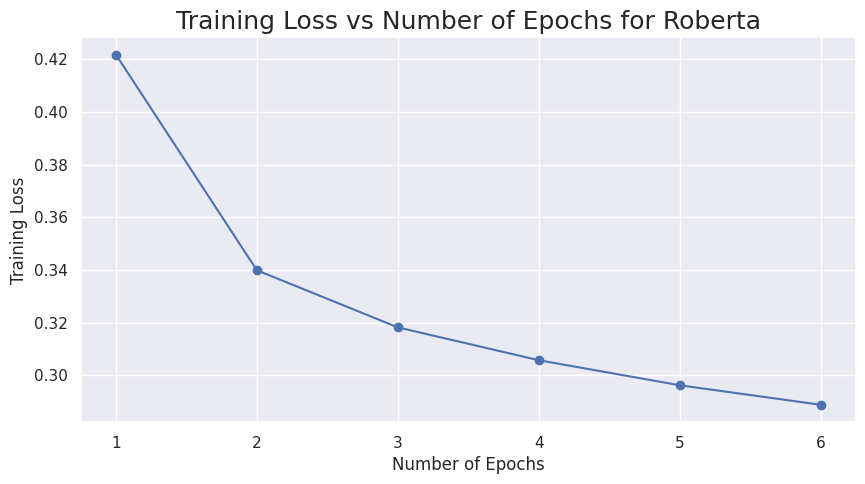

In [32]:
fig, ax = plt.subplots(figsize=(10, 5));
ax.plot(num_epochs, np.array(training_loss_list) ,'bo-',label="Train Loss")
ax.set_xlabel("Number of Epochs")
ax.set_ylabel("Training Loss")
ax.set_title("Training Loss vs Number of Epochs for Roberta",fontsize=18)

(0.0, 100.0)

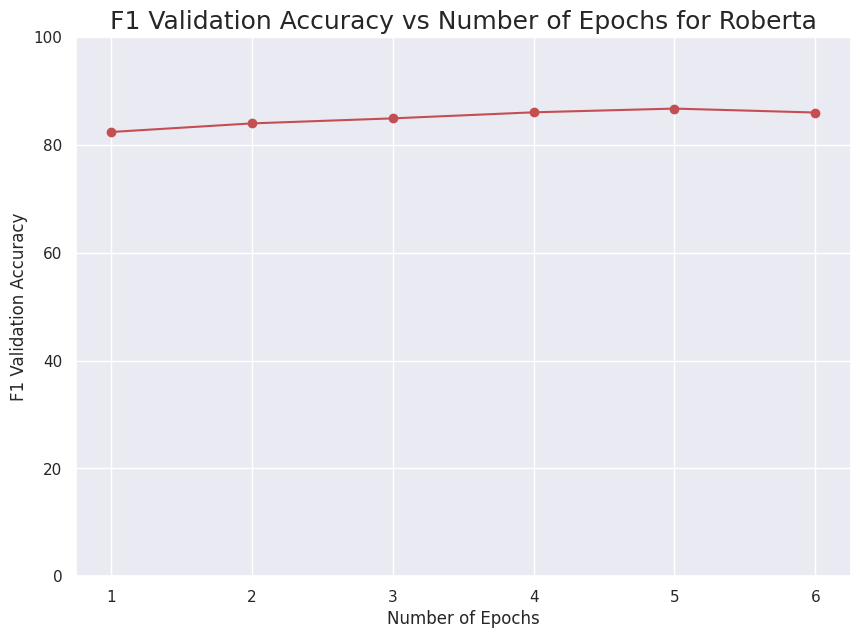

In [33]:
fig, ax = plt.subplots(figsize=(10, 7));
ax.plot(num_epochs, np.array(val_f1_accuracy_list),'ro-' ,label="F1 Validation Accuracy")
ax.set_xlabel("Number of Epochs")
ax.set_ylabel("F1 Validation Accuracy")
ax.set_title("F1 Validation Accuracy vs Number of Epochs for Roberta",fontsize=18)
ax.set_ylim(0, 100)

(0.0, 100.0)

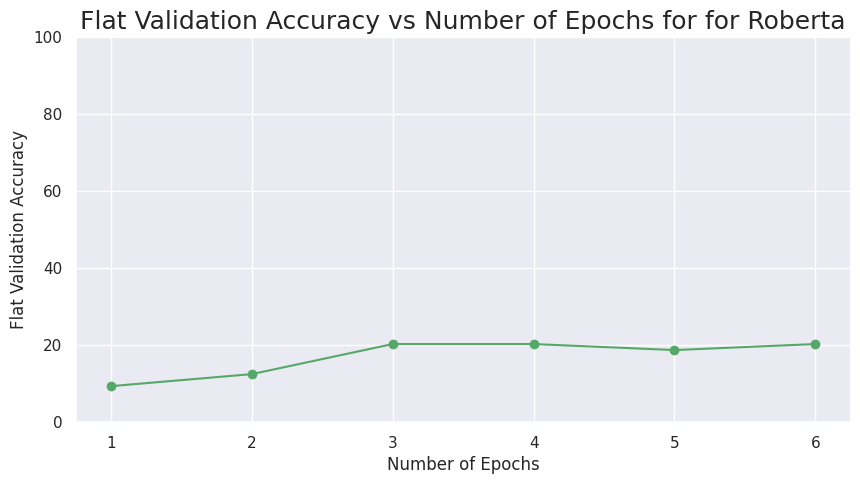

In [34]:
fig, ax = plt.subplots(figsize=(10, 5));
ax.plot(num_epochs, np.array(val_flat_accuracy_list),'go-', label="Flat Validation Accuracy")
ax.set_xlabel("Number of Epochs")
ax.set_ylabel("Flat Validation Accuracy")
ax.set_title("Flat Validation Accuracy vs Number of Epochs for for Roberta",fontsize=18)
ax.set_ylim(0, 100)

In [35]:
df_test['one_hot_labels'] = list(df_test[mesh_Heading_categories].values)
df_test.head(3)

,Title,abstractText,meshMajor,pmid,meshid,meshroot,A,B,C,D,...,F,G,H,I,J,L,M,N,Z,one_hot_labels
35083,Expression of N-methyl-d-aspartate receptor 1 ...,High levels of glutamate can be toxic to retin...,"['Analysis of Variance', 'Animals', 'Cell Deat...",17942238,"[['E05.318.740.150', 'N05.715.360.750.125', 'N...","['Analytical, Diagnostic and Therapeutic Techn...",1,1,1,1,...,0,1,0,0,0,0,0,1,0,"[1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0]"
9005,Protection of pregnant swine by vaccination ag...,The protection conferred on pregnant gilts by ...,"['Animals', 'Antibodies, Bacterial', 'Bacteria...",7150130,"[['B01.050'], ['D12.776.124.486.485.114.107', ...","['Organisms [B]', 'Chemicals and Drugs [D]', '...",0,1,1,1,...,0,1,0,0,0,0,0,1,0,"[0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0]"
23836,An examination of Escherichia coli strains iso...,Ninety-five strains of Escherichia coli isolat...,"['Animals', 'Antigens', 'Antigens, Bacterial',...",6135266,"[['B01.050'], ['D23.050'], ['D23.050.161'], ['...","['Organisms [B]', 'Chemicals and Drugs [D]', '...",1,1,1,1,...,0,1,0,0,0,0,0,0,0,"[1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]"


In [36]:
test_labels = list(df_test.one_hot_labels.values)
Articles_test = list(df_test.abstractText.values)
test_mesh_categories = list(df_test.columns[6:20])

In [37]:
# Encoding input data
test_encodings = tokenizer.batch_encode_plus(Articles_test,max_length=max_length,padding=True,truncation=True)
test_input_ids = test_encodings['input_ids']
test_attention_masks = test_encodings['attention_mask']

In [38]:
# Make tensors out of data
test_inputs = torch.tensor(test_input_ids)
test_labels = torch.tensor(test_labels)
test_masks = torch.tensor(test_attention_masks)
# Create test dataloader
test_data = TensorDataset(test_inputs, test_masks, test_labels,)# test_token_types)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)
# Save test dataloader
torch.save(test_dataloader,'test_data_loader')

In [39]:
%%time

# Test

# Put model in evaluation mode to evaluate loss on the validation set
model.eval()

#track variables
logit_preds,true_labels,pred_labels,tokenized_texts = [],[],[],[]

# Predict
for i, batch in enumerate(test_dataloader):
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels, = batch
    with torch.no_grad():
        # Forward pass
        outs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
        b_logit_pred = outs[0]
        pred_label = torch.sigmoid(b_logit_pred)

        b_logit_pred = b_logit_pred.detach().cpu().numpy()
        pred_label = pred_label.to('cpu').numpy()
        b_labels = b_labels.to('cpu').numpy()

    tokenized_texts.append(b_input_ids)
    logit_preds.append(b_logit_pred)
    true_labels.append(b_labels)
    pred_labels.append(pred_label)

# Flatten outputs
tokenized_texts = [item for sublist in tokenized_texts for item in sublist]
pred_labels = [item for sublist in pred_labels for item in sublist]
true_labels = [item for sublist in true_labels for item in sublist]
# Converting flattened binary values to boolean values
true_bools = [tl==1 for tl in true_labels]

CPU times: user 38.1 s, sys: 29 ms, total: 38.2 s
Wall time: 38.2 s


In [40]:
pred_bools = [pl>0.50 for pl in pred_labels] #boolean output after thresholding
# Print and save classification report
Test_F1_Accuracy=f1_score(true_bools, pred_bools,average='micro')
Test_Flat_Accuracy= accuracy_score(true_bools, pred_bools)
print('Test F1 Accuracy: ',Test_F1_Accuracy )
print('Test Flat Accuracy: ',Test_Flat_Accuracy,'\n')

df_test=pd.DataFrame({'Test F1 Accuracy':Test_F1_Accuracy, 'Test Flat Accuracy':Test_Flat_Accuracy},index=[0])

print(classification_report(true_bools,pred_bools,target_names=test_mesh_categories))
clf_report = classification_report(true_bools,pred_bools,target_names=test_mesh_categories,output_dict=True)
df_report=pd.DataFrame(clf_report).transpose()

Test F1 Accuracy:  0.8445904441417621
Test Flat Accuracy:  0.1571 

              precision    recall  f1-score   support

           A       0.78      0.77      0.78      4609
           B       0.96      0.99      0.97      9250
           C       0.87      0.88      0.87      5206
           D       0.91      0.93      0.92      6259
           E       0.81      0.94      0.87      7778
           F       0.87      0.65      0.74      1767
           G       0.82      0.89      0.86      6799
           H       0.63      0.08      0.14      1221
           I       0.71      0.47      0.56      1068
           J       0.72      0.43      0.54      1110
           L       0.75      0.36      0.48      1491
           M       0.88      0.87      0.88      4232
           N       0.83      0.75      0.79      4602
           Z       0.75      0.67      0.71      1558

   micro avg       0.86      0.83      0.84     56950
   macro avg       0.81      0.69      0.72     56950
weighted avg

In [41]:
df_report.to_csv('Classification_Report.csv',index=False)

In [42]:
model.save_pretrained('./Multi_label_Classification_Save/')
tokenizer.save_pretrained('./Multi_label_Classification_Save/')

('./Multi_label_Classification_Save/tokenizer_config.json',
 './Multi_label_Classification_Save/special_tokens_map.json',
 './Multi_label_Classification_Save/vocab.json',
 './Multi_label_Classification_Save/merges.txt',
 './Multi_label_Classification_Save/added_tokens.json')

## Bio-Bert

In [45]:
tokenizer = BertTokenizer.from_pretrained('dmis-lab/biobert-base-cased-v1.2', do_lower_case=True) 

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.11k [00:00<?, ?B/s]

In [46]:
encodings = tokenizer.batch_encode_plus(Article_train,max_length=max_length,padding=True,truncation=True) # tokenizer's encoding method
print('tokenizer outputs: ', encodings.keys())
input_ids = encodings['input_ids'] # tokenized and encoded sentences
attention_masks = encodings['attention_mask'] 

tokenizer outputs:  dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])


In [47]:
label_counts = df_train.one_hot_labels.astype(str).value_counts()
one_freq = label_counts[label_counts==1].keys()
one_freq_idxs = sorted(list(df_train[df_train.one_hot_labels.astype(str).isin(one_freq)].index), reverse=True)
print('df label indices with only one instance: ', one_freq_idxs)

df label indices with only one instance:  [49950, 49878, 49876, 49838, 49759, 49739, 49696, 49590, 49585, 49574, 49546, 49535, 49528, 49487, 49470, 49419, 49404, 49395, 49314, 49245, 49150, 49080, 49071, 49058, 49004, 48991, 48982, 48922, 48919, 48757, 48708, 48686, 48679, 48677, 48602, 48594, 48583, 48531, 48454, 48438, 48411, 48388, 48375, 48350, 48337, 48298, 48213, 48185, 48123, 48085, 48075, 48056, 48020, 48001, 47876, 47840, 47828, 47817, 47776, 47671, 47495, 47435, 47369, 47363, 47362, 47359, 47356, 47321, 47293, 47244, 47239, 47159, 47104, 47089, 47061, 47050, 47002, 46955, 46887, 46874, 46837, 46747, 46706, 46651, 46635, 46598, 46446, 46365, 46247, 46223, 46199, 46170, 46033, 46028, 45955, 45946, 45756, 45755, 45712, 45682, 45671, 45573, 45509, 45430, 45391, 45317, 45294, 45226, 45216, 45190, 45134, 45132, 45105, 45052, 45035, 45025, 44971, 44953, 44867, 44851, 44827, 44777, 44763, 44625, 44606, 44598, 44586, 44579, 44574, 44568, 44499, 44479, 44462, 44296, 44206, 44181, 44116

In [48]:
train_inputs, validation_inputs, train_labels, validation_labels, train_masks, validation_masks = train_test_split(input_ids, labels, attention_masks,
                                                            random_state=2020, test_size=0.20)

# Convert all of our data into torch tensors, the required datatype for our BERT Pytorch model
train_inputs = torch.tensor(train_inputs)
train_labels = torch.tensor(train_labels)
train_masks = torch.tensor(train_masks)

validation_inputs = torch.tensor(validation_inputs)
validation_labels = torch.tensor(validation_labels)
validation_masks = torch.tensor(validation_masks)

In [49]:
train_data =     TensorDataset(train_inputs, train_masks, train_labels,)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels,)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

In [50]:
torch.save(validation_dataloader,'validation_data_loader')
torch.save(train_dataloader,'train_data_loader')

In [51]:
model = BertForSequenceClassification.from_pretrained("dmis-lab/biobert-base-cased-v1.2", num_labels=num_labels)
model.cuda()
print('Model Pushed to Cuda for Training')

pytorch_model.bin:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of the model checkpoint at dmis-lab/biobert-base-cased-v1.2 were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification we

Model Pushed to Cuda for Training


In [52]:
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

In [53]:
optimizer = AdamW(optimizer_grouped_parameters,lr=6e-6)

In [54]:
os.environ['TF_FORCE_GPU_ALLOW_GROWTH']='true'

In [56]:
%%time
wandb.init(project="Multi Label Classification of PubMed Articles (Paper Night Presentation)",name=f"42.Roberta-base-cased-v1.2-Run-27")
# For Storing our loss and accuracy for plotting
train_loss_set = []
val_f1_accuracy_list,val_flat_accuracy_list,training_loss_list,epochs_list=[],[],[],[]

# Number of training epochs (recommend between 5 and 10)
epochs = 6

# trange is a tqdm wrapper around the normal python range
for _ in trange(epochs, desc="Epoch "):
    # Training

    # Set our model to training mode (as opposed to evaluation mode)
    model.train()

    # Tracking variables
    tr_loss = 0 #running loss
    nb_tr_examples, nb_tr_steps = 0, 0
  
    # Train the data for one epoch
    for step, batch in enumerate(train_dataloader):
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels= batch
        # Clear out the gradients (by default they accumulate)
        optimizer.zero_grad()
        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
        logits = outputs[0]
        loss_func = BCEWithLogitsLoss()  
        loss = loss_func(logits.view(-1,num_labels),b_labels.type_as(logits).view(-1,num_labels)) #convert labels to float for calculation
        
        train_loss_set.append(loss.item())    

        # Backward pass
        loss.backward()
        # Update parameters and take a step using the computed gradient
        optimizer.step()
        # scheduler.step()
        # Update tracking variables
        tr_loss += loss.item()
        nb_tr_examples += b_input_ids.size(0)
        nb_tr_steps += 1

    print("Train loss: {}".format(tr_loss/nb_tr_steps))
    training_loss_list.append(tr_loss/nb_tr_steps)

    ###############################################################################

    # Validation

    # Put model in evaluation mode to evaluate loss on the validation set
    model.eval()

    # Variables to gather full output
    logit_preds,true_labels,pred_labels,tokenized_texts = [],[],[],[]

    # Predict
    for i, batch in enumerate(validation_dataloader):
        batch = tuple(t.to(device) for t in batch)
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        with torch.no_grad():
            # Forward pass
            outs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
            b_logit_pred = outs[0]
            pred_label = torch.sigmoid(b_logit_pred)

        b_logit_pred = b_logit_pred.detach().cpu().numpy()
        pred_label = pred_label.to('cpu').numpy()
        b_labels = b_labels.to('cpu').numpy()

    tokenized_texts.append(b_input_ids)
    logit_preds.append(b_logit_pred)
    true_labels.append(b_labels)
    pred_labels.append(pred_label)

    # Flatten outputs
    pred_labels = [item for sublist in pred_labels for item in sublist]
    true_labels = [item for sublist in true_labels for item in sublist]

    # Calculate Accuracy
    threshold = 0.50
    pred_bools = [pl>threshold for pl in pred_labels]
    true_bools = [tl==1 for tl in true_labels]
    val_f1_accuracy = f1_score(true_bools,pred_bools,average='micro')*100
    val_flat_accuracy = accuracy_score(true_bools, pred_bools)*100

    print('F1 Validation Accuracy: ', val_f1_accuracy)  
    print('Flat Validation Accuracy: ', val_flat_accuracy)
    print('\n')
    val_f1_accuracy_list.append(val_f1_accuracy)
    val_flat_accuracy_list.append(val_flat_accuracy)
    epochs_list.append(epochs)  
    
    wandb.log({"train_loss":tr_loss/nb_tr_steps,"val_f1_accuracy":val_f1_accuracy,"val_flat_accuracy":val_flat_accuracy,})
wandb.finish()

wandb: Currently logged in as: ibetanibex (ai-guru). Use `wandb login --relogin` to force relogin


Epoch :   0%|          | 0/6 [00:00<?, ?it/s]

Train loss: 0.33013722956180575


Epoch :  17%|█▋        | 1/6 [12:01<1:00:06, 721.31s/it]

F1 Validation Accuracy:  86.53846153846155
Flat Validation Accuracy:  15.625


Train loss: 0.303013403236866


Epoch :  33%|███▎      | 2/6 [24:01<48:03, 720.84s/it]  

F1 Validation Accuracy:  87.51714677640604
Flat Validation Accuracy:  21.875


Train loss: 0.286097248762846


Epoch :  50%|█████     | 3/6 [36:01<36:01, 720.49s/it]

F1 Validation Accuracy:  87.1012482662968
Flat Validation Accuracy:  18.75


Train loss: 0.2730027217268944


Epoch :  67%|██████▋   | 4/6 [48:02<24:01, 720.71s/it]

F1 Validation Accuracy:  87.29281767955803
Flat Validation Accuracy:  20.3125


Train loss: 0.2610986169278622


Epoch :  83%|████████▎ | 5/6 [1:00:05<12:01, 721.29s/it]

F1 Validation Accuracy:  87.01657458563537
Flat Validation Accuracy:  18.75


Train loss: 0.25086801254749297


Epoch : 100%|██████████| 6/6 [1:12:06<00:00, 721.02s/it]

F1 Validation Accuracy:  86.96844993141289
Flat Validation Accuracy:  18.75




train_loss,█▆▄▃▂▁
val_f1_accuracy,▁█▅▆▄▄
val_flat_accuracy,▁█▅▆▅▅
train_loss,0.25087
val_f1_accuracy,86.96845
val_flat_accuracy,18.75


CPU times: user 1h 12min 6s, sys: 2.09 s, total: 1h 12min 8s
Wall time: 1h 12min 41s


In [57]:
num_epochs = np.arange(1,len(training_loss_list)+1)
df_train_results=pd.DataFrame({'Epochs':num_epochs,'F1 Validation Accuracy':val_f1_accuracy_list,\
                               'Flat Validation Accuracy':val_flat_accuracy_list,'Train loss':training_loss_list})

Text(0.5, 1.0, 'Training Loss vs Number of Epochs for Bert-Base')

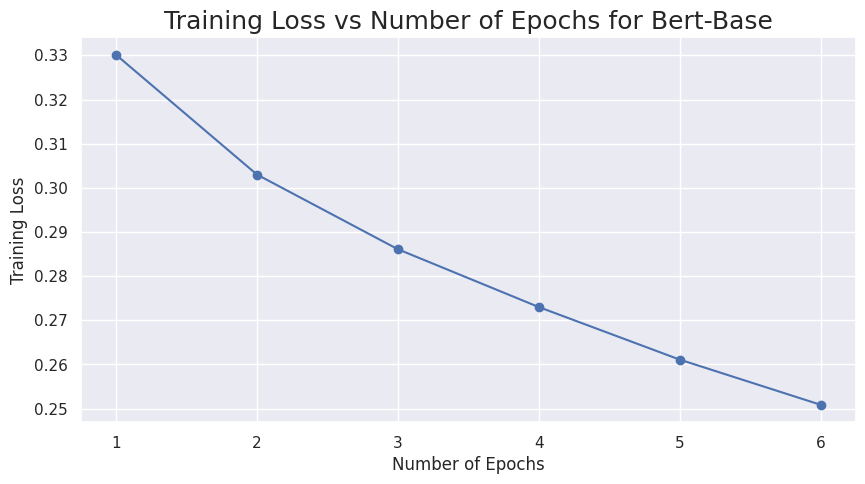

In [58]:
fig, ax = plt.subplots(figsize=(10, 5));
ax.plot(num_epochs, np.array(training_loss_list) ,'bo-',label="Train Loss")
ax.set_xlabel("Number of Epochs")
ax.set_ylabel("Training Loss")
ax.set_title("Training Loss vs Number of Epochs for Bert-Base",fontsize=18)

(0.0, 100.0)

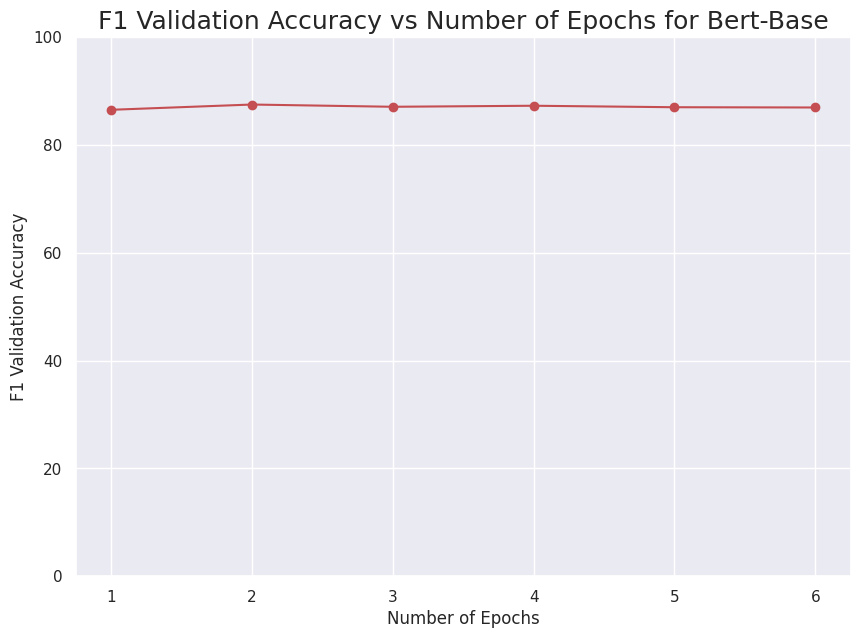

In [59]:
fig, ax = plt.subplots(figsize=(10, 7));
ax.plot(num_epochs, np.array(val_f1_accuracy_list),'ro-' ,label="F1 Validation Accuracy")
ax.set_xlabel("Number of Epochs")
ax.set_ylabel("F1 Validation Accuracy")
ax.set_title("F1 Validation Accuracy vs Number of Epochs for Bert-Base",fontsize=18)
ax.set_ylim(0, 100)

(0.0, 100.0)

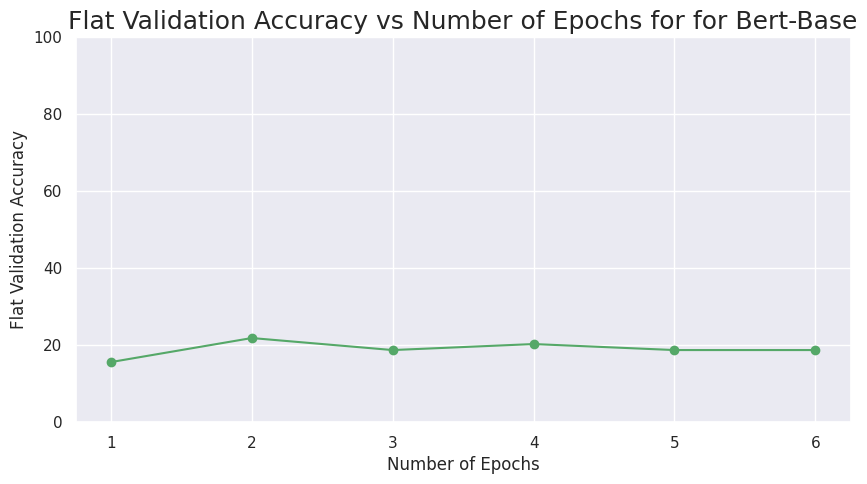

In [60]:

fig, ax = plt.subplots(figsize=(10, 5));
ax.plot(num_epochs, np.array(val_flat_accuracy_list),'go-', label="Flat Validation Accuracy")
ax.set_xlabel("Number of Epochs")
ax.set_ylabel("Flat Validation Accuracy")
ax.set_title("Flat Validation Accuracy vs Number of Epochs for for Bert-Base",fontsize=18)
ax.set_ylim(0, 100)


In [67]:
df_train, df_test = train_test_split(df, random_state=32, test_size=0.20, shuffle=True)
print(df_train.shape)
print(df_test.shape)
del(df)

(40000, 20)
(10000, 20)


In [68]:
df_test['one_hot_labels'] = list(df_test[mesh_Heading_categories].values)
df_test.head(3)

,Title,abstractText,meshMajor,pmid,meshid,meshroot,A,B,C,D,...,F,G,H,I,J,L,M,N,Z,one_hot_labels
35083,Expression of N-methyl-d-aspartate receptor 1 ...,High levels of glutamate can be toxic to retin...,"['Analysis of Variance', 'Animals', 'Cell Deat...",17942238,"[['E05.318.740.150', 'N05.715.360.750.125', 'N...","['Analytical, Diagnostic and Therapeutic Techn...",1,1,1,1,...,0,1,0,0,0,0,0,1,0,"[1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0]"
9005,Protection of pregnant swine by vaccination ag...,The protection conferred on pregnant gilts by ...,"['Animals', 'Antibodies, Bacterial', 'Bacteria...",7150130,"[['B01.050'], ['D12.776.124.486.485.114.107', ...","['Organisms [B]', 'Chemicals and Drugs [D]', '...",0,1,1,1,...,0,1,0,0,0,0,0,1,0,"[0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0]"
23836,An examination of Escherichia coli strains iso...,Ninety-five strains of Escherichia coli isolat...,"['Animals', 'Antigens', 'Antigens, Bacterial',...",6135266,"[['B01.050'], ['D23.050'], ['D23.050.161'], ['...","['Organisms [B]', 'Chemicals and Drugs [D]', '...",1,1,1,1,...,0,1,0,0,0,0,0,0,0,"[1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]"


In [69]:
test_labels = list(df_test.one_hot_labels.values)
Articles_test = list(df_test.abstractText.values)
test_mesh_categories = list(df_test.columns[6:20])

In [70]:
test_encodings = tokenizer.batch_encode_plus(Articles_test,max_length=max_length,padding=True,truncation=True)
test_input_ids = test_encodings['input_ids']
test_attention_masks = test_encodings['attention_mask']

In [71]:
test_inputs = torch.tensor(test_input_ids)
test_labels = torch.tensor(test_labels)
test_masks = torch.tensor(test_attention_masks)
# Create test dataloader
test_data = TensorDataset(test_inputs, test_masks, test_labels,)# test_token_types)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)
# Save test dataloader
torch.save(test_dataloader,'test_data_loader')

In [72]:
%%time

# Test

# Put model in evaluation mode to evaluate loss on the validation set
model.eval()

#track variables
logit_preds,true_labels,pred_labels,tokenized_texts = [],[],[],[]

# Predict
for i, batch in enumerate(test_dataloader):
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels, = batch
    with torch.no_grad():
        # Forward pass
        outs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
        b_logit_pred = outs[0]
        pred_label = torch.sigmoid(b_logit_pred)

        b_logit_pred = b_logit_pred.detach().cpu().numpy()
        pred_label = pred_label.to('cpu').numpy()
        b_labels = b_labels.to('cpu').numpy()

    tokenized_texts.append(b_input_ids)
    logit_preds.append(b_logit_pred)
    true_labels.append(b_labels)
    pred_labels.append(pred_label)

# Flatten outputs
tokenized_texts = [item for sublist in tokenized_texts for item in sublist]
pred_labels = [item for sublist in pred_labels for item in sublist]
true_labels = [item for sublist in true_labels for item in sublist]
# Converting flattened binary values to boolean values
true_bools = [tl==1 for tl in true_labels]

CPU times: user 1min 14s, sys: 25 ms, total: 1min 14s
Wall time: 1min 14s


In [73]:
pred_bools = [pl>0.50 for pl in pred_labels] #boolean output after thresholding
# Print and save classification report
Test_F1_Accuracy=f1_score(true_bools, pred_bools,average='micro')
Test_Flat_Accuracy= accuracy_score(true_bools, pred_bools)
print('Test F1 Accuracy: ',Test_F1_Accuracy )
print('Test Flat Accuracy: ',Test_Flat_Accuracy,'\n')

df_test=pd.DataFrame({'Test F1 Accuracy':Test_F1_Accuracy, 'Test Flat Accuracy':Test_Flat_Accuracy},index=[0])

print(classification_report(true_bools,pred_bools,target_names=test_mesh_categories))
clf_report = classification_report(true_bools,pred_bools,target_names=test_mesh_categories,output_dict=True)
df_report=pd.DataFrame(clf_report).transpose()

Test F1 Accuracy:  0.8557193019325574
Test Flat Accuracy:  0.1779 

              precision    recall  f1-score   support

           A       0.78      0.83      0.81      4609
           B       0.96      0.99      0.97      9250
           C       0.88      0.89      0.89      5206
           D       0.92      0.93      0.92      6259
           E       0.80      0.98      0.88      7778
           F       0.85      0.71      0.77      1767
           G       0.83      0.89      0.86      6799
           H       0.58      0.13      0.22      1221
           I       0.72      0.55      0.63      1068
           J       0.75      0.54      0.63      1110
           L       0.71      0.46      0.56      1491
           M       0.88      0.90      0.89      4232
           N       0.82      0.78      0.80      4602
           Z       0.75      0.67      0.71      1558

   micro avg       0.85      0.86      0.86     56950
   macro avg       0.80      0.73      0.75     56950
weighted avg

In [74]:
df_report.to_csv('Classification_Report_BERTSEQ.csv',index=False)

In [75]:
model.save_pretrained('./Multi_label_Classification_Save_bertseq/')
tokenizer.save_pretrained('./Multi_label_Classification_Save_bertseq/')

('./Multi_label_Classification_Save_bertseq/tokenizer_config.json',
 './Multi_label_Classification_Save_bertseq/special_tokens_map.json',
 './Multi_label_Classification_Save_bertseq/vocab.txt',
 './Multi_label_Classification_Save_bertseq/added_tokens.json')

## XLNet

In [79]:
df_train, df_test = train_test_split(df, random_state=32, test_size=0.20, shuffle=True)
print(df_train.shape)
print(df_test.shape)
del(df)

(40000, 20)
(10000, 20)


In [80]:
df_test['one_hot_labels'] = list(df_test[mesh_Heading_categories].values)
df_test.head(3)

,Title,abstractText,meshMajor,pmid,meshid,meshroot,A,B,C,D,...,F,G,H,I,J,L,M,N,Z,one_hot_labels
35083,Expression of N-methyl-d-aspartate receptor 1 ...,High levels of glutamate can be toxic to retin...,"['Analysis of Variance', 'Animals', 'Cell Deat...",17942238,"[['E05.318.740.150', 'N05.715.360.750.125', 'N...","['Analytical, Diagnostic and Therapeutic Techn...",1,1,1,1,...,0,1,0,0,0,0,0,1,0,"[1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0]"
9005,Protection of pregnant swine by vaccination ag...,The protection conferred on pregnant gilts by ...,"['Animals', 'Antibodies, Bacterial', 'Bacteria...",7150130,"[['B01.050'], ['D12.776.124.486.485.114.107', ...","['Organisms [B]', 'Chemicals and Drugs [D]', '...",0,1,1,1,...,0,1,0,0,0,0,0,1,0,"[0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0]"
23836,An examination of Escherichia coli strains iso...,Ninety-five strains of Escherichia coli isolat...,"['Animals', 'Antigens', 'Antigens, Bacterial',...",6135266,"[['B01.050'], ['D23.050'], ['D23.050.161'], ['...","['Organisms [B]', 'Chemicals and Drugs [D]', '...",1,1,1,1,...,0,1,0,0,0,0,0,0,0,"[1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]"


In [81]:
tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased', do_lower_case=False)
encodings = tokenizer.batch_encode_plus(Article_train,max_length=max_length,padding=True,truncation=True) # tokenizer's encoding method
print('tokenizer outputs: ', encodings.keys())

input_ids = encodings['input_ids'] # tokenized and encoded sentences
attention_masks = encodings['attention_mask']

spiece.model:   0%|          | 0.00/798k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/760 [00:00<?, ?B/s]

tokenizer outputs:  dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])


In [83]:
df_train['one_hot_labels'] = list(df_train[mesh_Heading_categories].values)
df_train.head(3)

,Title,abstractText,meshMajor,pmid,meshid,meshroot,A,B,C,D,...,F,G,H,I,J,L,M,N,Z,one_hot_labels
31112,Neurofibromatosis associated with a coronary a...,A case of a patient with type 1 neurofibromato...,"['Aged', 'Coronary Aneurysm', 'Humans', 'Male'...",11144803,"[['M01.060.116.100'], ['C14.280.647.250.250', ...","['Named Groups [M]', 'Diseases [C]', 'Organism...",0,1,1,0,...,0,0,0,0,0,0,1,0,0,"[0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0]"
48911,Phenolic constituents from Perovskia atriplici...,"Perovskoate, an isorinic acid derivative (1) a...","['Caffeic Acids', 'Catechols', 'Cholinesterase...",16644529,"[['D02.241.223.200.054'], ['D02.455.426.559.38...","['Chemicals and Drugs [D]', 'Analytical, Diagn...",0,1,0,1,...,0,1,0,0,0,0,0,0,0,"[0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0]"
16394,Motion artifact and background noise suppressi...,Optical coherence tomography (OCT) is a techni...,"['Algorithms', 'Angiography', 'Artifacts', 'Ar...",25089975,"[['G17.035', 'L01.224.050'], ['E01.370.350.700...","['Phenomena and Processes [G]', 'Information S...",0,0,0,0,...,0,1,0,0,0,1,0,1,0,"[0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0]"


In [84]:
label_counts = df_train.one_hot_labels.astype(str).value_counts()
one_freq = label_counts[label_counts==1].keys()
one_freq_idxs = sorted(list(df_train[df_train.one_hot_labels.astype(str).isin(one_freq)].index), reverse=True)
print('df label indices with only one instance: ', one_freq_idxs)

df label indices with only one instance:  [49950, 49878, 49876, 49838, 49759, 49739, 49696, 49590, 49585, 49574, 49546, 49535, 49528, 49487, 49470, 49419, 49404, 49395, 49314, 49245, 49150, 49080, 49071, 49058, 49004, 48991, 48982, 48922, 48919, 48757, 48708, 48686, 48679, 48677, 48602, 48594, 48583, 48531, 48454, 48438, 48411, 48388, 48375, 48350, 48337, 48298, 48213, 48185, 48123, 48085, 48075, 48056, 48020, 48001, 47876, 47840, 47828, 47817, 47776, 47671, 47495, 47435, 47369, 47363, 47362, 47359, 47356, 47321, 47293, 47244, 47239, 47159, 47104, 47089, 47061, 47050, 47002, 46955, 46887, 46874, 46837, 46747, 46706, 46651, 46635, 46598, 46446, 46365, 46247, 46223, 46199, 46170, 46033, 46028, 45955, 45946, 45756, 45755, 45712, 45682, 45671, 45573, 45509, 45430, 45391, 45317, 45294, 45226, 45216, 45190, 45134, 45132, 45105, 45052, 45035, 45025, 44971, 44953, 44867, 44851, 44827, 44777, 44763, 44625, 44606, 44598, 44586, 44579, 44574, 44568, 44499, 44479, 44462, 44296, 44206, 44181, 44116

In [85]:
train_inputs, validation_inputs, train_labels, validation_labels, train_masks, validation_masks = train_test_split(input_ids, labels, attention_masks,
                                                            random_state=2020, test_size=0.20)

# Convert all of our data into torch tensors, the required datatype for our BERT Pytorch model
train_inputs = torch.tensor(train_inputs)
train_labels = torch.tensor(train_labels)
train_masks = torch.tensor(train_masks)

validation_inputs = torch.tensor(validation_inputs)
validation_labels = torch.tensor(validation_labels)
validation_masks = torch.tensor(validation_masks)

In [86]:
train_data =     TensorDataset(train_inputs, train_masks, train_labels,)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels,)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

In [87]:
torch.save(validation_dataloader,'validation_data_loader')
torch.save(train_dataloader,'train_data_loader')

In [88]:
model = XLNetForSequenceClassification.from_pretrained("xlnet-base-cased", num_labels=num_labels)
model.cuda()
print('Model Pushed to Cuda for Training')

pytorch_model.bin:   0%|          | 0.00/467M [00:00<?, ?B/s]

Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForSequenceClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['sequence_summary.summary.bias', 'logits_proj.weight', 'logits_proj.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions a

Model Pushed to Cuda for Training


In [89]:
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

In [90]:
optimizer = AdamW(model.parameters(),lr=4e-5)  # Default optimization

In [91]:
os.environ['TF_FORCE_GPU_ALLOW_GROWTH']='true'

In [92]:
%%time
wandb.init(project="Multi Label Classification of PubMed Articles (Paper Night Presentation)",name=f"42.XLNET-base-cased-v1.2-Run-27")
# For Storing our loss and accuracy for plotting
train_loss_set = []
val_f1_accuracy_list,val_flat_accuracy_list,training_loss_list,epochs_list=[],[],[],[]

# Number of training epochs (recommend between 5 and 10)
epochs = 6

# trange is a tqdm wrapper around the normal python range
for _ in trange(epochs, desc="Epoch "):
    # Training

    # Set our model to training mode (as opposed to evaluation mode)
    model.train()

    # Tracking variables
    tr_loss = 0 #running loss
    nb_tr_examples, nb_tr_steps = 0, 0
  
    # Train the data for one epoch
    for step, batch in enumerate(train_dataloader):
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels= batch
        # Clear out the gradients (by default they accumulate)
        optimizer.zero_grad()
        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
        logits = outputs[0]
        loss_func = BCEWithLogitsLoss()  
        loss = loss_func(logits.view(-1,num_labels),b_labels.type_as(logits).view(-1,num_labels)) #convert labels to float for calculation
        
        train_loss_set.append(loss.item())    

        # Backward pass
        loss.backward()
        # Update parameters and take a step using the computed gradient
        optimizer.step()
        # scheduler.step()
        # Update tracking variables
        tr_loss += loss.item()
        nb_tr_examples += b_input_ids.size(0)
        nb_tr_steps += 1

    print("Train loss: {}".format(tr_loss/nb_tr_steps))
    training_loss_list.append(tr_loss/nb_tr_steps)

    ###############################################################################

    # Validation

    # Put model in evaluation mode to evaluate loss on the validation set
    model.eval()

    # Variables to gather full output
    logit_preds,true_labels,pred_labels,tokenized_texts = [],[],[],[]

    # Predict
    for i, batch in enumerate(validation_dataloader):
        batch = tuple(t.to(device) for t in batch)
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        with torch.no_grad():
            # Forward pass
            outs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
            b_logit_pred = outs[0]
            pred_label = torch.sigmoid(b_logit_pred)

        b_logit_pred = b_logit_pred.detach().cpu().numpy()
        pred_label = pred_label.to('cpu').numpy()
        b_labels = b_labels.to('cpu').numpy()

    tokenized_texts.append(b_input_ids)
    logit_preds.append(b_logit_pred)
    true_labels.append(b_labels)
    pred_labels.append(pred_label)

    # Flatten outputs
    pred_labels = [item for sublist in pred_labels for item in sublist]
    true_labels = [item for sublist in true_labels for item in sublist]

    # Calculate Accuracy
    threshold = 0.50
    pred_bools = [pl>threshold for pl in pred_labels]
    true_bools = [tl==1 for tl in true_labels]
    val_f1_accuracy = f1_score(true_bools,pred_bools,average='micro')*100
    val_flat_accuracy = accuracy_score(true_bools, pred_bools)*100

    print('F1 Validation Accuracy: ', val_f1_accuracy)  
    print('Flat Validation Accuracy: ', val_flat_accuracy)
    print('\n')
    val_f1_accuracy_list.append(val_f1_accuracy)
    val_flat_accuracy_list.append(val_flat_accuracy)
    epochs_list.append(epochs)  
    
    wandb.log({"train_loss":tr_loss/nb_tr_steps,"val_f1_accuracy":val_f1_accuracy,"val_flat_accuracy":val_flat_accuracy,})
wandb.finish()

Epoch :   0%|          | 0/6 [00:00<?, ?it/s]

Train loss: 0.3313789011836052


Epoch :  17%|█▋        | 1/6 [16:42<1:23:33, 1002.68s/it]

F1 Validation Accuracy:  86.73050615595076
Flat Validation Accuracy:  21.875


Train loss: 0.2840878330171108


Epoch :  33%|███▎      | 2/6 [33:25<1:06:50, 1002.72s/it]

F1 Validation Accuracy:  86.71328671328672
Flat Validation Accuracy:  17.1875


Train loss: 0.2581644724011421


Epoch :  50%|█████     | 3/6 [50:08<50:08, 1002.78s/it]  

F1 Validation Accuracy:  86.8238557558946
Flat Validation Accuracy:  18.75


Train loss: 0.23289570665359496


Epoch :  67%|██████▋   | 4/6 [1:06:51<33:25, 1002.78s/it]

F1 Validation Accuracy:  85.90785907859079
Flat Validation Accuracy:  15.625


Train loss: 0.2055249029994011


Epoch :  83%|████████▎ | 5/6 [1:23:34<16:42, 1002.86s/it]

F1 Validation Accuracy:  87.0748299319728
Flat Validation Accuracy:  17.1875


Train loss: 0.17651128944754602


Epoch : 100%|██████████| 6/6 [1:40:17<00:00, 1002.84s/it]

F1 Validation Accuracy:  85.52097428958052
Flat Validation Accuracy:  14.0625




train_loss,█▆▅▄▂▁
val_f1_accuracy,▆▆▇▃█▁
val_flat_accuracy,█▄▅▂▄▁
train_loss,0.17651
val_f1_accuracy,85.52097
val_flat_accuracy,14.0625


CPU times: user 1h 41min 23s, sys: 3.19 s, total: 1h 41min 26s
Wall time: 1h 40min 51s


In [93]:
num_epochs = np.arange(1,len(training_loss_list)+1)
df_train_results=pd.DataFrame({'Epochs':num_epochs,'F1 Validation Accuracy':val_f1_accuracy_list,\
                               'Flat Validation Accuracy':val_flat_accuracy_list,'Train loss':training_loss_list})

Text(0, 0.5, 'Training Loss')

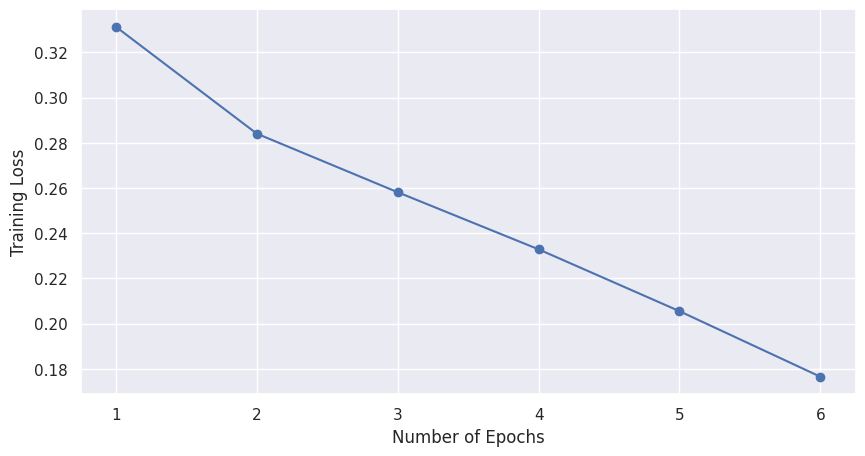

In [94]:
fig, ax = plt.subplots(figsize=(10, 5));
ax.plot(num_epochs, np.array(training_loss_list) ,'bo-',label="Train Loss")
ax.set_xlabel("Number of Epochs")
ax.set_ylabel("Training Loss")


(0.0, 100.0)

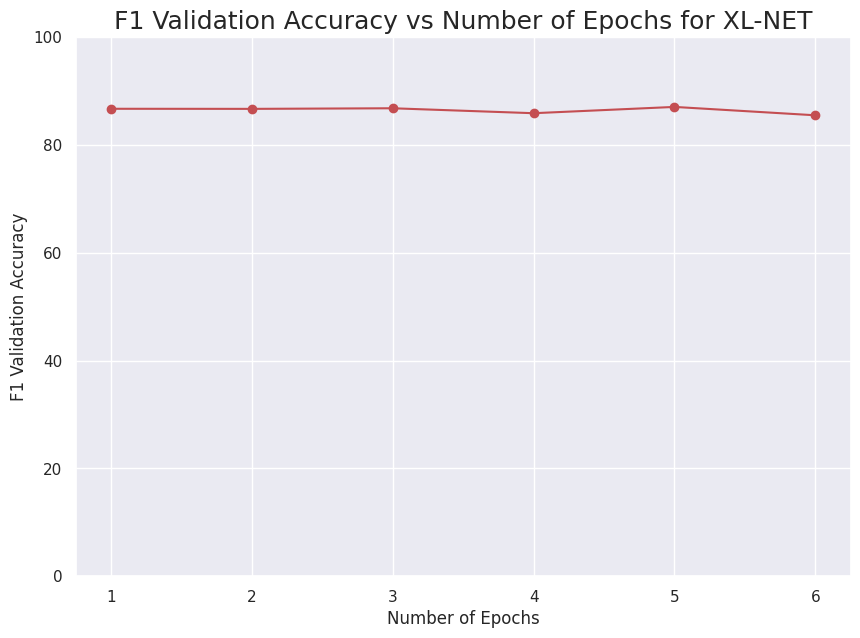

In [96]:
fig, ax = plt.subplots(figsize=(10, 7));
ax.plot(num_epochs, np.array(val_f1_accuracy_list),'ro-' ,label="F1 Validation Accuracy")
ax.set_xlabel("Number of Epochs")
ax.set_ylabel("F1 Validation Accuracy")
ax.set_title("F1 Validation Accuracy vs Number of Epochs for XL-NET",fontsize=18)
ax.set_ylim(0, 100)

(0.0, 100.0)

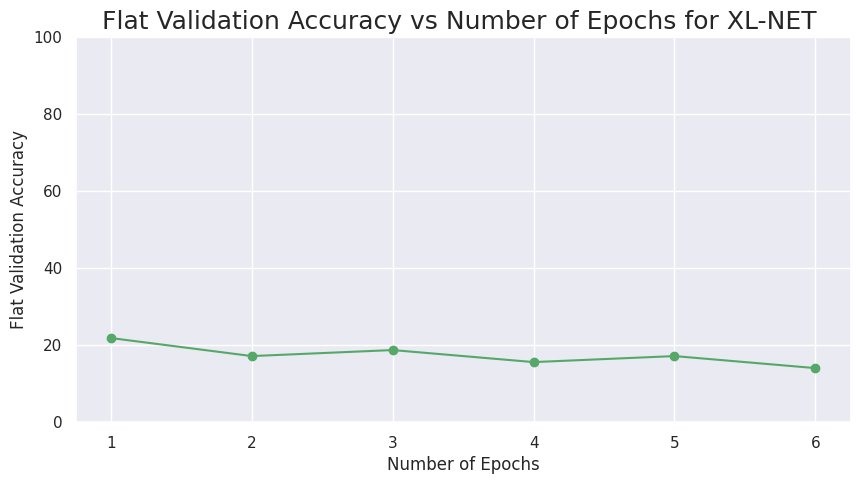

In [97]:
fig, ax = plt.subplots(figsize=(10, 5));
ax.plot(num_epochs, np.array(val_flat_accuracy_list),'go-', label="Flat Validation Accuracy")
ax.set_xlabel("Number of Epochs")
ax.set_ylabel("Flat Validation Accuracy")
ax.set_title("Flat Validation Accuracy vs Number of Epochs for XL-NET ",fontsize=18)
ax.set_ylim(0, 100)

In [98]:
df_test['one_hot_labels'] = list(df_test[mesh_Heading_categories].values)
df_test.head(3)

,Title,abstractText,meshMajor,pmid,meshid,meshroot,A,B,C,D,...,F,G,H,I,J,L,M,N,Z,one_hot_labels
35083,Expression of N-methyl-d-aspartate receptor 1 ...,High levels of glutamate can be toxic to retin...,"['Analysis of Variance', 'Animals', 'Cell Deat...",17942238,"[['E05.318.740.150', 'N05.715.360.750.125', 'N...","['Analytical, Diagnostic and Therapeutic Techn...",1,1,1,1,...,0,1,0,0,0,0,0,1,0,"[1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0]"
9005,Protection of pregnant swine by vaccination ag...,The protection conferred on pregnant gilts by ...,"['Animals', 'Antibodies, Bacterial', 'Bacteria...",7150130,"[['B01.050'], ['D12.776.124.486.485.114.107', ...","['Organisms [B]', 'Chemicals and Drugs [D]', '...",0,1,1,1,...,0,1,0,0,0,0,0,1,0,"[0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0]"
23836,An examination of Escherichia coli strains iso...,Ninety-five strains of Escherichia coli isolat...,"['Animals', 'Antigens', 'Antigens, Bacterial',...",6135266,"[['B01.050'], ['D23.050'], ['D23.050.161'], ['...","['Organisms [B]', 'Chemicals and Drugs [D]', '...",1,1,1,1,...,0,1,0,0,0,0,0,0,0,"[1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]"


In [99]:
test_labels = list(df_test.one_hot_labels.values)
Articles_test = list(df_test.abstractText.values)
test_mesh_categories = list(df_test.columns[6:20])

In [100]:
test_encodings = tokenizer.batch_encode_plus(Articles_test,max_length=max_length,padding=True,truncation=True)
test_input_ids = test_encodings['input_ids']
test_attention_masks = test_encodings['attention_mask']

In [101]:
test_inputs = torch.tensor(test_input_ids)
test_labels = torch.tensor(test_labels)
test_masks = torch.tensor(test_attention_masks)
# Create test dataloader
test_data = TensorDataset(test_inputs, test_masks, test_labels,)# test_token_types)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)
# Save test dataloader
torch.save(test_dataloader,'test_data_loader')

In [103]:
%%time

# Test

# Put model in evaluation mode to evaluate loss on the validation set
model.eval()

#track variables
logit_preds,true_labels,pred_labels,tokenized_texts = [],[],[],[]

# Predict
for i, batch in enumerate(test_dataloader):
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels, = batch
    with torch.no_grad():
        # Forward pass
        outs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
        b_logit_pred = outs[0]
        pred_label = torch.sigmoid(b_logit_pred)

        b_logit_pred = b_logit_pred.detach().cpu().numpy()
        pred_label = pred_label.to('cpu').numpy()
        b_labels = b_labels.to('cpu').numpy()

    tokenized_texts.append(b_input_ids)
    logit_preds.append(b_logit_pred)
    true_labels.append(b_labels)
    pred_labels.append(pred_label)

# Flatten outputs
tokenized_texts = [item for sublist in tokenized_texts for item in sublist]
pred_labels = [item for sublist in pred_labels for item in sublist]
true_labels = [item for sublist in true_labels for item in sublist]
# Converting flattened binary values to boolean values
true_bools = [tl==1 for tl in true_labels]

CPU times: user 1min 55s, sys: 1.16 s, total: 1min 56s
Wall time: 1min 53s


In [105]:
pred_bools = [pl>0.50 for pl in pred_labels] #boolean output after thresholding
# Print and save classification report
Test_F1_Accuracy=f1_score(true_bools, pred_bools,average='micro')
Test_Flat_Accuracy= accuracy_score(true_bools, pred_bools)
print('Test F1 Accuracy: ',Test_F1_Accuracy )
print('Test Flat Accuracy: ',Test_Flat_Accuracy,'\n')
df_test=pd.DataFrame({'Test F1 Accuracy':Test_F1_Accuracy, 'Test Flat Accuracy':Test_Flat_Accuracy},index=[0])
print(classification_report(true_bools,pred_bools,target_names=test_mesh_categories))
clf_report = classification_report(true_bools,pred_bools,target_names=test_mesh_categories,output_dict=True)
df_report=pd.DataFrame(clf_report).transpose()

Test F1 Accuracy:  0.8427982526302837
Test Flat Accuracy:  0.1512 

              precision    recall  f1-score   support

           A       0.83      0.70      0.76      4609
           B       0.96      0.98      0.97      9250
           C       0.86      0.88      0.87      5206
           D       0.92      0.91      0.91      6259
           E       0.81      0.95      0.87      7778
           F       0.76      0.78      0.77      1767
           G       0.84      0.86      0.85      6799
           H       0.51      0.26      0.34      1221
           I       0.67      0.61      0.63      1068
           J       0.66      0.57      0.61      1110
           L       0.57      0.55      0.56      1491
           M       0.88      0.88      0.88      4232
           N       0.80      0.78      0.79      4602
           Z       0.76      0.67      0.71      1558

   micro avg       0.84      0.84      0.84     56950
   macro avg       0.77      0.74      0.75     56950
weighted avg

In [106]:
df_report.to_csv('Classification_Report_XLNET.csv',index=False)

In [107]:
model.save_pretrained('./Multi_label_Classification_Save_xlnet/')
tokenizer.save_pretrained('./Multi_label_Classification_Save_xlnet/')

('./Multi_label_Classification_Save_xlnet/tokenizer_config.json',
 './Multi_label_Classification_Save_xlnet/special_tokens_map.json',
 './Multi_label_Classification_Save_xlnet/spiece.model',
 './Multi_label_Classification_Save_xlnet/added_tokens.json')